# DU-GD法 (最小二乗問題)

周期性条件なし

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

### 準備 (グローバル定数の設定)

In [2]:
n = 50　
m = 100　
num_itr = 50
K = 100 
adam_lr = 1e-4
max_inner = 40

A = randn(m,n)
Pinv = (A'*A)^(-1)*A'
eig = eigvals(A'*A)
λmin = minimum(eig)
λmax = maximum(eig)
ηopt = 2/(λmin + λmax)

0.006420414030917664

### ミニバッチ生成関数

In [3]:
function mini_batch(K)
    y = randn(m,K)
    x_opt = Pinv*y
    return y, x_opt
end

mini_batch (generic function with 1 method)

### 固定ステップサイズのGD法のMSE

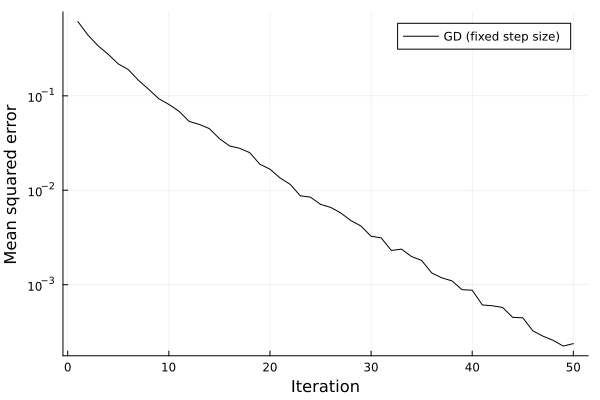

In [4]:
function GD(max_itr, y)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - ηopt*A'*(A*x - y)
    end
    return x
end

function comp_mse(max_itr)
    y, x_opt = mini_batch(K)
    x̂ = GD(max_itr, y)
    return norm(x_opt - x̂)^2/K
end
        
GD_mse = [comp_mse(i) for i in 1:num_itr]
plot(1:num_itr, GD_mse, lw=1, yscale=:log10, label="GD (fixed step size)", color=:black,  xlabel="Iteration", ylabel="Mean squared error")

### DU-GD反復の定義 

In [5]:
function DU_GD(max_itr, y, η)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - η[i]*A'*(A*x - y)
    end
    return x
end

DU_GD (generic function with 1 method)

### 損失関数の定義

In [6]:
function loss(x_opt, x̂)
    return norm(x_opt - x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [7]:
function train(opt, η)
    ps = Flux.params(η) 
    for itr in 1:num_itr
        for i in 1:max_inner
            y, x_opt = mini_batch(K)
            gs = Flux.gradient(ps) do
                x̂ = DU_GD(itr, y, η)
                loss(x_opt, x̂)
            end
            Flux.Optimise.update!(opt, ps, gs)
        end
        y, x_opt = mini_batch(K)
        x_est = DU_GD(itr, y, η)
        println(itr, " ", loss(x_opt, x_est))
    end
end

train (generic function with 1 method)

### DU-GDのMSE評価用関数

In [8]:
function comp_mse_DUGD(max_itr, η)
    y, x_opt = mini_batch(K)
    x̂ = DU_GD(max_itr, y, η)
    return loss(x_opt, x̂)
end

comp_mse_DUGD (generic function with 1 method)

### 学習過程

1 0.7366693435028967
2 0.4725527957363341
3 0.3079298562574127
4 0.2109654855858727
5 0.14530374797223414
6 0.10152551737910016
7 0.06789663488272363
8 0.0442114796640505
9 0.03468313652338825
10 0.02545462917290336
11 0.01544247979450266
12 0.012043642041413762
13 0.011040088244449148
14 0.007616975691242574
15 0.0056043246540795275
16 0.004079560357990325
17 0.0028097367750205176
18 0.0023706786097397754
19 0.0020641075956957145
20 0.0012854792755445216
21 0.0008468959166273225
22 0.000539950050254575
23 0.0003061849066104443
24 0.00021693905092491056
25 0.0002935596904673592
26 0.00019990922483914867
27 0.0001331284972183742
28 9.153195534184989e-5
29 5.9643448363199654e-5
30 3.239106948256433e-5
31 2.4917635189041693e-5
32 1.413139415120875e-5
33 1.7290827038722763e-5
34 9.14926349407241e-6
35 7.4511812853452105e-6
36 4.556582264925044e-6
37 2.9214597441239107e-6
38 3.5396254189688283e-6
39 1.9014409597850532e-6
40 1.2505506300621716e-6
41 7.362187318994265e-7
42 5.937056645726063e

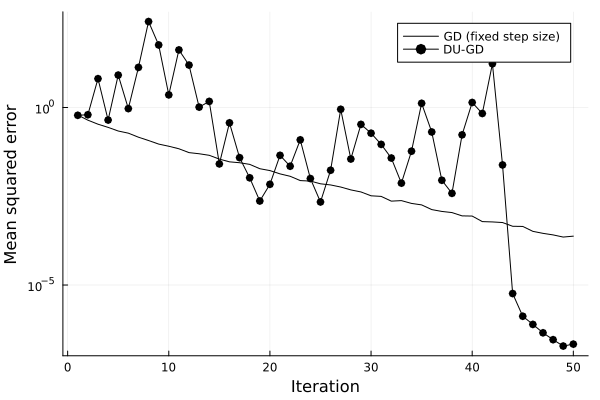

In [9]:
η_train = zeros(num_itr) 
opt = Flux.ADAM(adam_lr) 
train(opt, η_train)
DUGD_mse =[comp_mse_DUGD(i, η_train) for i in 1:num_itr]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD", color=:black, marker=:o)

In [10]:
savefig("DU-GD-LMS2.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_3/DU-GD-LMS2.pdf"

### 最適パラメータのプロット

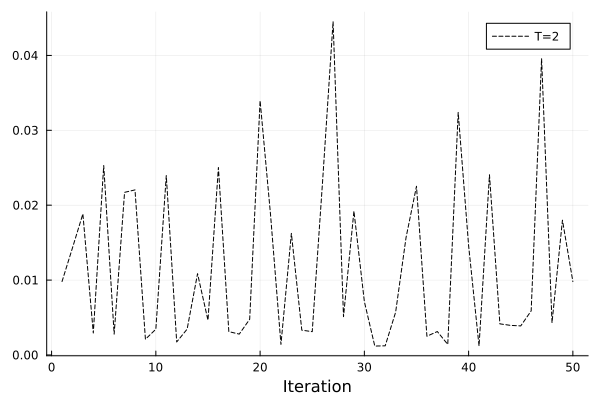

In [11]:
plot(1:num_itr, η_train, lw=1, label="T=2", color=:black, ls=:dash, xlabel="Iteration")

In [12]:
savefig("DU-GD-LMS2-param.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_3/DU-GD-LMS2-param.pdf"